## Intro
This code will show the whole code flow of our proposed ADANS method. For the Kyoto 2006+ dataset, the Anomaly Detector in ADANS uses the AutoEncoder anomaly detection model.


In [1]:
%load_ext autoreload
%autoreload 2
#表示每次Import导入的都是最新的模块，在修改代码后不用刷新kernel

## import packages
import sys
sys.path.append('../moudles/')
#这个baselines代码中不存在
sys.path.append('../')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import _pickle as pkl
import AE
import torch
from ShiftDetector import ShiftDetector
from ShiftAdapter import ShiftAdapter
import myutils as utils

## Prepare Anomaly Detector model and data

In [27]:
utils.set_random_seed()
feat = np.load('./data/2007.npz')
X, y = feat['X'], feat['y']
X_ben = X[y==0]
train_num=50000
X_train = X_ben[:train_num]
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
result= AE.train(X_train,feature_size)
model=result[0]
thres =result[1]
prev_params=result[2]
memory_factors=result[3]

epoch:0/10 |Loss: 0.013792422600090504
epoch:1/10 |Loss: 0.013447404839098454
epoch:2/10 |Loss: 0.013002714142203331
epoch:3/10 |Loss: 0.012609494850039482
epoch:4/10 |Loss: 0.012191148474812508
epoch:5/10 |Loss: 0.011781789362430573
epoch:6/10 |Loss: 0.011332525871694088
epoch:7/10 |Loss: 0.010742062702775002
epoch:8/10 |Loss: 0.009929811581969261
epoch:9/10 |Loss: 0.008891166187822819
max AD score 0.1436113


## See how AE performs on new data (data where normality shifts occur) and old data (data where normality shifts do not occur)

In [28]:
FEAT_0 = np.load('./data/2007.npz')
X_0, y_0 = scaler.transform(FEAT_0['X']), FEAT_0['y']
FEAT_1 = np.load('./data/2011.npz')
X_1, y_1 = scaler.transform(FEAT_1['X']), FEAT_1['y']

****************************** Before Normality Shift occurs ******************************
*********************** The relevant test indicators are as follows ***********************
FPR: 0.00990333333333333
Precision: 0.8623581190641649
Recall: 0.18614
F1_Score: 0.3061890858247317
AUC: 0.9473572145166667


<IPython.core.display.Javascript object>


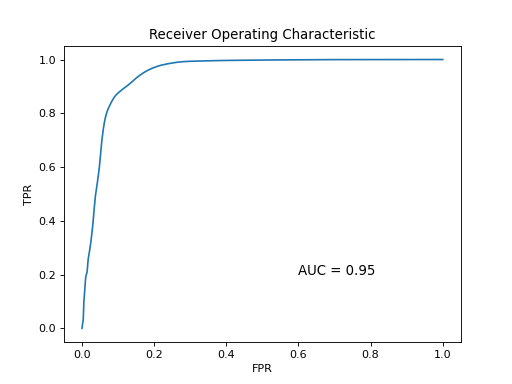

In [29]:
print('****************************** Before Normality Shift occurs ******************************')
y_pred_0, y_prob_0 = AE.test(model, thres, X_0)
utils.TPR_FPR(y_prob_0, y_0, thres)
utils.multi_metrics(y_prob_0, y_0, thres*1.5)
#利用test()函数将每个均方根误差大于thres的样本的y_pred_0设置为1，否则为0，然后y_prob_0表示每个样本的均方根误差

****************************** After Normality Shift occurs ******************************
*********************** The relevant test indicators are as follows ***********************
FPR: 0.0274300914336381
Precision: 0.4699858302202757
Recall: 0.07296927030729693
F1_Score: 0.12632544773083348
AUC: 0.8070476900256349


<IPython.core.display.Javascript object>


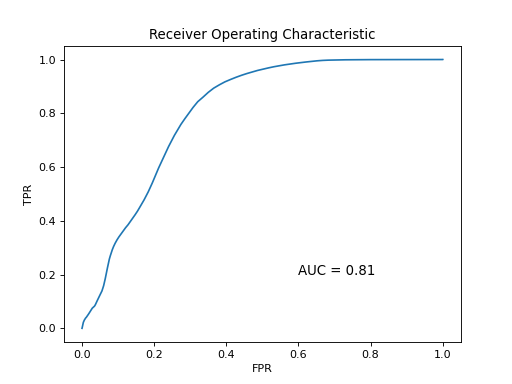

In [30]:
print('****************************** After Normality Shift occurs ******************************')
y_pred_1, y_prob_1 = AE.test(model, thres, X_1)
utils.TPR_FPR(y_prob_1, y_1, thres)
utils.multi_metrics(y_prob_1, y_1, thres*1.5)
#Q：这个thres_max=thres*1.5是如何设定的？

**Obviously, the new data shows a 14% decrease in the AUC metric, and all other metrics show a significant decrease in the performance of the anomaly detection model.
Next, let's use ADANS to address the problem of anomaly detection models facing normality shift**.

## Let's use ADANS！

In [31]:
vali_num = 100000
rmse_o = y_prob_0[:vali_num]
rmse_n = y_prob_1[:vali_num]
X_o = X_0[:vali_num]
X_n = X_1[:vali_num]

## Detection of normality shift using Normality Shift Detector

Amplify differences between values that differ between rmse_o
均值： 0.1870122104883194
方差： 0.008092152886092663
Amplify differences between values that differ between rmse_n
均值： 0.3385131359100342
方差： 0.005764104891568422
Wasserstein distance between old set and new set is: 0.0
No normality shift!Shift! P-value is 1.0
Visualize Shift:


<IPython.core.display.Javascript object>


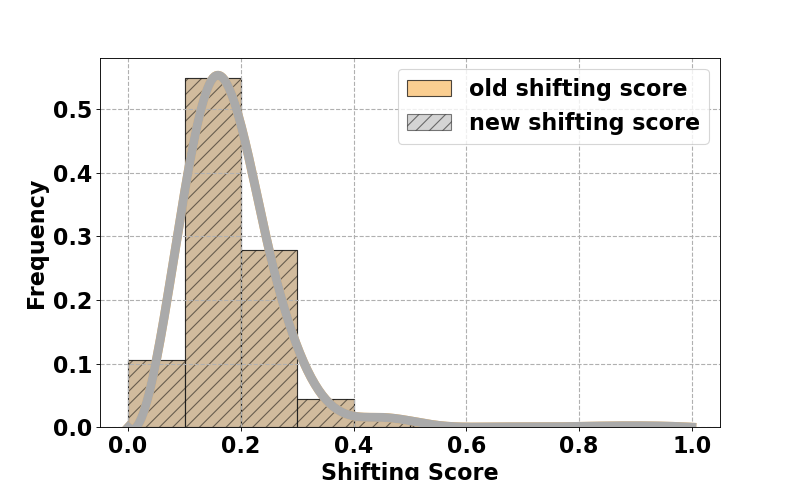

In [32]:
%matplotlib notebook
utils.set_random_seed()
sd = ShiftDetector(method='min_max')
print("Amplify differences between values that differ between rmse_o")
score_o=sd.process(rmse_o)
print("Amplify differences between values that differ between rmse_n")
score_n=sd.process(rmse_n)

t = utils.get_params('ShiftDetector')['test_thres']
p_value = sd.Monte_Carlo(score_o,score_o)[0]
if p_value >= t:
    print("No normality shift!Shift! P-value is", p_value)
else:
    print('Shift! P-value is', p_value)
print("Visualize Shift:")
sd.visualize_hists(score_o,score_o)

## Adaption of normality shift using Normality Shift Adapter

In [12]:
utils.set_random_seed()
sa = ShiftAdapter()
label_num= 10000
# 设置标签代价为验证集的10%
exp_result = sa.select_Tab(X_o,X_n,y_n,label_num,feature_size) 

epoch:0/50 domain_loss 0.15493300557136536
epoch:1/50 domain_loss 0.12867553532123566
epoch:2/50 domain_loss 0.11955412477254868
epoch:3/50 domain_loss 0.09028002619743347
epoch:4/50 domain_loss 0.11098332703113556
epoch:5/50 domain_loss 0.08956241607666016
epoch:6/50 domain_loss 0.08277915418148041
epoch:7/50 domain_loss 0.09406673163175583
epoch:8/50 domain_loss 0.07583853602409363
epoch:9/50 domain_loss 0.0793466567993164
epoch:10/50 domain_loss 0.08749374002218246
epoch:11/50 domain_loss 0.07316593080759048
epoch:12/50 domain_loss 0.05767505615949631
epoch:13/50 domain_loss 0.06487023085355759
epoch:14/50 domain_loss 0.05565293878316879
epoch:15/50 domain_loss 0.06584109365940094
epoch:16/50 domain_loss 0.05239154025912285
epoch:17/50 domain_loss 0.061732277274131775
epoch:18/50 domain_loss 0.052655331790447235
epoch:19/50 domain_loss 0.06771734356880188
epoch:20/50 domain_loss 0.044885165989398956
epoch:21/50 domain_loss 0.059733934700489044
epoch:22/50 domain_loss 0.0558555871248

In [13]:
sa.adapter_t(model,label_num,prev_params,memory_factors)

epoch:0/50 |Loss: 2.5085325241088867
epoch:1/50 |Loss: 2.2664802074432373
epoch:2/50 |Loss: 2.2709057331085205
epoch:3/50 |Loss: 2.239391326904297
epoch:4/50 |Loss: 2.2147576808929443
epoch:5/50 |Loss: 2.156306266784668
epoch:6/50 |Loss: 2.2020106315612793
epoch:7/50 |Loss: 2.3096561431884766
epoch:8/50 |Loss: 2.0240774154663086
epoch:9/50 |Loss: 1.9716728925704956
epoch:10/50 |Loss: 2.0227880477905273
epoch:11/50 |Loss: 1.9105373620986938
epoch:12/50 |Loss: 1.8875294923782349
epoch:13/50 |Loss: 1.9190351963043213
epoch:14/50 |Loss: 1.923459768295288
epoch:15/50 |Loss: 1.9644726514816284
epoch:16/50 |Loss: 1.836852788925171
epoch:17/50 |Loss: 1.8081668615341187
epoch:18/50 |Loss: 1.8155293464660645
epoch:19/50 |Loss: 1.8967797756195068
epoch:20/50 |Loss: 1.9191176891326904
epoch:21/50 |Loss: 1.8341326713562012
epoch:22/50 |Loss: 2.0035805702209473
epoch:23/50 |Loss: 1.9184614419937134
epoch:24/50 |Loss: 1.8464657068252563
epoch:25/50 |Loss: 1.8258516788482666
epoch:26/50 |Loss: 1.78606

## Re-testing the performance of the anomaly detection model (AE) on new data

In [33]:
%matplotlib notebook
print('****************************** After adapting the ADNS method to normality shift ******************************')
y_pred, y_prob = AE.test(sa.model,thres, X_1)
utils.TPR_FPR(y_prob, y_1, thres)
utils.multi_metrics(y_prob, y_1, thres*1.5)

****************************** After adapting the ADNS method to normality shift ******************************


NameError: name 'sa' is not defined

**(As we can see that, ADANS improves the performance of AD models from 0.81 to 0.89 with 10k labels, which is 10% of validation set)**

## Contrasting methods: retraining
A common practice to tackle concept drift is to retrain the model with both old and new samples. Here we'll show whether retraining works in this example.

In [ ]:
utils.set_random_seed()
X_retrain = np.concatenate((X_0[:train_num],X_1[:label_num]))
result=AE.train(X_retrain, X_retrain.shape[-1])
retrain_model=result[0]
retrain_thres=result[1]

print('After Retraining:')
y_pred, y_prob = AE.test(retrain_model, retrain_thres, X_1)
AE.test_plot(y_prob,thres, label=y_1)
utils.TPR_FPR(y_prob, y_1, thres)
utils.multi_metrics(y_prob, y_1, retrain_thres*1.5) 


**(As we can see that, Retraining actually has a negtive effect. Please refer to our paper for more analysis)**